# PREDICTING VOLATILITY FOR A VOLTARGET STRATEGY

In [24]:
import pandas as pd
import numpy as np


In [25]:
# plotly is an advanced visualization tool

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import pandas_datareader as web
import plotly.graph_objects as go
import plotly as ply


#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader as web

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
df = web.get_data_yahoo("^GSPC",
                            start = "1999-01-01",
                            end = "2020-05-05")


In [28]:
df=df.reset_index()
dates=df['Date']
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,1999-01-04,1248.810059,1219.099976,1229.229980,1228.099976,877000000,1228.099976
1,1999-01-05,1246.109985,1228.099976,1228.099976,1244.780029,775000000,1244.780029
2,1999-01-06,1272.500000,1244.780029,1244.780029,1272.339966,986900000,1272.339966
3,1999-01-07,1272.339966,1257.680054,1272.339966,1269.729980,863000000,1269.729980
4,1999-01-08,1278.239990,1261.819946,1269.729980,1275.089966,937800000,1275.089966


In [29]:
df.shape

(5369, 7)

In [30]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,1999-01-04,1248.810059,1219.099976,1229.229980,1228.099976,877000000,1228.099976
1,1999-01-05,1246.109985,1228.099976,1228.099976,1244.780029,775000000,1244.780029
2,1999-01-06,1272.500000,1244.780029,1244.780029,1272.339966,986900000,1272.339966
3,1999-01-07,1272.339966,1257.680054,1272.339966,1269.729980,863000000,1269.729980
4,1999-01-08,1278.239990,1261.819946,1269.729980,1275.089966,937800000,1275.089966


## GARCH (1,1)

In [31]:
df['log_price'] = np.log(df['Adj Close']) #Firstly we should take the logarithmic return from prices

In [32]:
df['pct_change'] = df['log_price'].diff() #after that let's take difference

In [33]:
df['stdev'] = df['pct_change'].rolling(window=20, center=False).std()
df['Volatility'] = df['stdev'] * (252**0.5) # Annualize.

In [85]:
df.mean()

High            1.596179e+03
Low             1.576837e+03
Open            1.586899e+03
Close           1.587094e+03
Volume          3.028955e+09
Adj Close       1.587094e+03
log_price       7.306532e+00
pct_change      1.518774e-04
stdev           1.043116e-02
Volatility      1.655895e-01
forecast_vol    7.545171e-02
dtype: float64

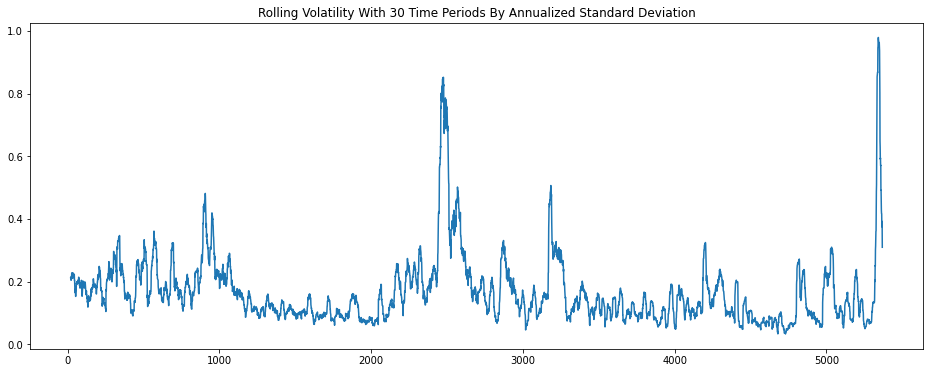

In [35]:
plt.figure(figsize=(16,6))
df['Volatility'].plot()
plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
plt.show()

In [36]:
df = df.dropna()

In [37]:
vol = df["Volatility"] * 100

__The GARCH(1,1) model is:__

$$\sigma^2(t) = \alpha \times \sigma^2(t-1) + \beta \times e^2(t-1) + w$$

In [38]:
!pip install arch

In [39]:
from arch import arch_model
am = arch_model(vol, vol='Garch', p=1, o=0, q=1, dist='Normal')

In [40]:
res = am.fit(disp='off')
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Volatility   R-squared:                      -0.277
Mean Model:             Constant Mean   Adj. R-squared:                 -0.277
Vol Model:                      GARCH   Log-Likelihood:               -15484.8
Distribution:                  Normal   AIC:                           30977.7
Method:            Maximum Likelihood   BIC:                           31004.0
                                        No. Observations:                 5349
Date:                Fri, Jul 10 2020   Df Residuals:                     5345
Time:                        07:38:05   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10.6827      0.245     43.640      0.000 [ 10.203, 11.163]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5749  8.431e-02      6.819  9.186e-12 [  0.410,  0.740]
alpha[1]       0.9926  5.900e-02     16.824  1.633e-63 [  0.877,  1.108]
beta[1]        0.0000  5.235e-02      0.000      1.000 [ -0.103,  0.103]
========================================================================

Covariance estimator: robust
"""

In [41]:
df['forecast_vol'] = 0.01 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + 
                                   res.conditional_volatility**2 * res.params['beta[1]'])

After fitting the GARCH(1,1) model, by the formula above, it is possible to forecast rolling volatility. The last 10 rows of the final form of the data is displayed below.

In [42]:
display(df.tail(10))

,Date,High,Low,Open,Close,Volume,Adj Close,log_price,pct_change,stdev,Volatility,forecast_vol
5359,2020-04-22,2815.100098,2775.949951,2787.889893,2799.310059,5049660000,2799.310059,7.937128,0.022671,0.030947,0.491262,0.383092
5360,2020-04-23,2844.899902,2794.260010,2810.419922,2797.800049,5756520000,2797.800049,7.936589,-0.000540,0.030966,0.491572,0.383400
5361,2020-04-24,2842.709961,2791.760010,2812.639893,2836.739990,5374480000,2836.739990,7.950411,0.013822,0.028291,0.449105,0.341099
5362,2020-04-27,2887.719971,2852.889893,2854.649902,2878.479980,5194260000,2878.479980,7.965018,0.014607,0.026908,0.427156,0.319237
5363,2020-04-28,2921.149902,2860.709961,2909.959961,2863.389893,5672880000,2863.389893,7.959761,-0.005256,0.026259,0.416843,0.308965
5364,2020-04-29,2954.860107,2912.159912,2918.459961,2939.510010,6620140000,2939.510010,7.985998,0.026237,0.026231,0.416402,0.308525
5365,2020-04-30,2930.909912,2892.469971,2930.909912,2912.429932,6523120000,2912.429932,7.976743,-0.009255,0.023613,0.374852,0.267143
5366,2020-05-01,2869.090088,2821.610107,2869.090088,2830.709961,4753160000,2830.709961,7.948283,-0.028460,0.024713,0.392315,0.284535
5367,2020-05-04,2844.239990,2797.850098,2815.010010,2842.739990,4723140000,2842.739990,7.952524,0.004241,0.024224,0.384547,0.276799
5368,2020-05-05,2898.229980,2863.550049,2868.879883,2868.439941,5129590000,2868.439941,7.961524,0.009000,0.019495,0.309479,0.202046


As it is expected it is seen in the graph below that, GARCH (1,1) model is a weak learner for such a time series. 

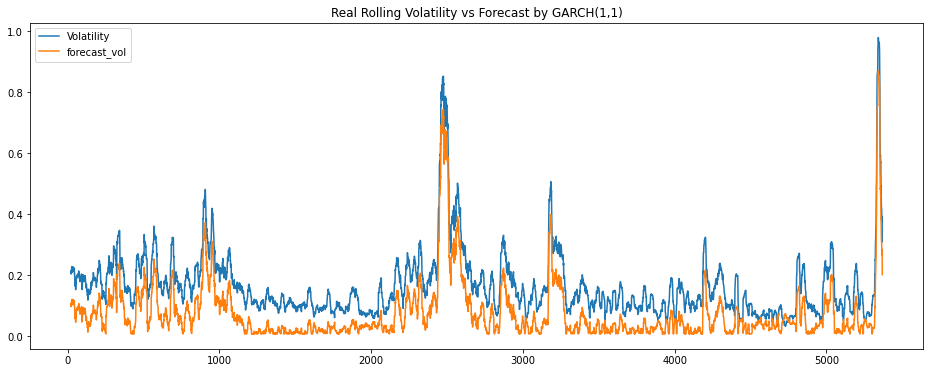

In [43]:
plt.figure(figsize=(16,6))
df["Volatility"].plot()
df["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(1,1)")
plt.legend()
plt.show()

In order to measure the performance of the model, __Root Mean Squared Error__ is used and the output of this measure for the last 1000 observations is shown below.
$$\sum{\sqrt{(\hat{X_i}-X_i)^2}}$$

In [44]:
def rmse_tr(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
skor = rmse_tr(df['forecast_vol'], df['Volatility'])
print("Root Mean Squared Error of the model is calculated as ",skor)

Root Mean Squared Error of the model is calculated as  0.09463045383934152


__Now the question is, by using the outputs of the GARCH (1,1) model as inputs, can we build a strong learner model?__
To find the answer of this question, we will use __Recurrent Neural Networks__ and the GARCH (1,1) outputs will be inputs along with real rolling volatilities

## LSTM
__Firstly it is necessary to forecast volatility by the real rolling volatilities to be able to measure the performance two different models alone.__

In [45]:
df.shape

(5349, 12)

In [92]:
training_set = df.iloc[:, 10:11].values
# 100 timestep ve 1 çıktı ile data yapısı oluşturalım
X_train = []
y_train = []
for i in range(100, df.shape[0]):
    X_train.append(training_set[i-100:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [93]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [94]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [95]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
#regressor.add(LSTM(units = 10, return_sequences = True))
#regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
#regressor.add(LSTM(units = 10, return_sequences = True))
#regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 16))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae'])

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, validation_split=0.1, shuffle=False, epochs = 30, batch_size = 32)

Train on 4724 samples, validate on 525 samples
Epoch 1/30
4724/4724 [==============================] - 14s 3ms/step - loss: 0.0065 - mae: 0.0539 - val_loss: 0.0097 - val_mae: 0.0475
Epoch 2/30
4724/4724 [==============================] - 14s 3ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 0.0050 - val_mae: 0.0370
Epoch 3/30
4724/4724 [==============================] - 13s 3ms/step - loss: 0.0015 - mae: 0.0269 - val_loss: 0.0036 - val_mae: 0.0316
Epoch 4/30
4724/4724 [==============================] - 13s 3ms/step - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0026 - val_mae: 0.0271
Epoch 5/30
4724/4724 [==============================] - 13s 3ms/step - loss: 0.0011 - mae: 0.0226 - val_loss: 0.0020 - val_mae: 0.0250
Epoch 6/30
4724/4724 [==============================] - 14s 3ms/step - loss: 8.8497e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0246
Epoch 7/30
4724/4724 [==============================] - 13s 3ms/step - loss: 8.2299e-04 - mae: 0.0197 - val_loss: 0.0017 - val_mae: 0.0231


In [96]:
regressor.save('my_modelp1.h5')

In [97]:
from keras.models import load_model
regressor = load_model('my_modelp1.h5')

In [98]:
predicted_stock_price = regressor.predict(X_train)


In [99]:
len(predicted_stock_price)

5249

In [100]:
df.iloc[:,10:11]

,Volatility
20,0.211716
21,0.208395
22,0.204416
23,0.205640
24,0.205413
...,...
5364,0.416402
5365,0.374852
5366,0.392315
5367,0.384547


In [101]:
len(df['Volatility'])

5349

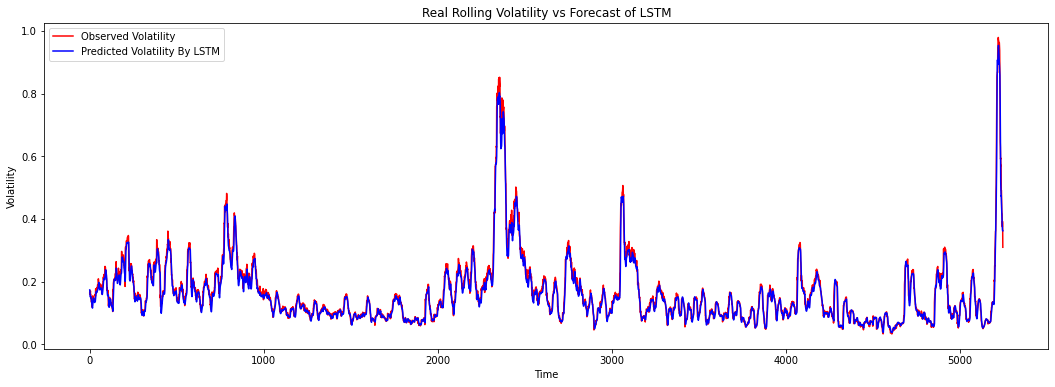

In [102]:
# Visualising the results
plt.figure(figsize=(18,6))
plt.plot(df.iloc[100:,10:11].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM')
plt.title('Real Rolling Volatility vs Forecast of LSTM')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

Remark: the graphic might be illusional because we had too many data points in it. Compute MAPE and try to make better results by combining the garch results.

On the other hand, we should be aware of the mimick behaviours of the LSTM (random walk property) and how our model try to mimicks the real data with a lag.


In [103]:
skor2 = rmse_tr(predicted_stock_price, np.array(df.loc[df.index[100:], 'Volatility']))
print("Root Mean Squared Error of the model is calculated as ",skor2)

Root Mean Squared Error of the model is calculated as  0.15498870317103514


## Neural-Garch Model (Combining Garch(1,1) and LSTM)

In [104]:
training_set = df.iloc[:, 10:12].values
training_set.size

10698

In [105]:
training_set = df.iloc[:, 10:12].values
# rolling window with 100 data
X_train = []
y_train = []
for i in range(100, df.shape[0]):
    X_train.append(training_set[i-100:i,:])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [106]:
X_train.shape

(5249, 100, 2)

In [107]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))

In [109]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train.shape[1], 2)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 16))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
#regressor.add(LSTM(units = 64, return_sequences = True))
#regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
#regressor.add(LSTM(units = 32))
#regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['mae'])

# Fitting the RNN to the Training set
history=regressor.fit(X_train, y_train,  validation_split=0.1, shuffle=False, epochs = 40, batch_size = 32)

Train on 4724 samples, validate on 525 samples
Epoch 1/40
4724/4724 [==============================] - 13s 3ms/step - loss: 0.0062 - mae: 0.0531 - val_loss: 0.0067 - val_mae: 0.0446
Epoch 2/40
4724/4724 [==============================] - 13s 3ms/step - loss: 0.0018 - mae: 0.0297 - val_loss: 0.0044 - val_mae: 0.0382
Epoch 3/40
4724/4724 [==============================] - 13s 3ms/step - loss: 0.0014 - mae: 0.0264 - val_loss: 0.0031 - val_mae: 0.0335
Epoch 4/40
4724/4724 [==============================] - 13s 3ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 0.0025 - val_mae: 0.0317
Epoch 5/40
4724/4724 [==============================] - 13s 3ms/step - loss: 9.6146e-04 - mae: 0.0223 - val_loss: 0.0024 - val_mae: 0.0322
Epoch 6/40
4724/4724 [==============================] - 13s 3ms/step - loss: 8.8060e-04 - mae: 0.0213 - val_loss: 0.0026 - val_mae: 0.0336
Epoch 7/40
4724/4724 [==============================] - 13s 3ms/step - loss: 8.6947e-04 - mae: 0.0205 - val_loss: 0.0020 - val_mae: 0.0

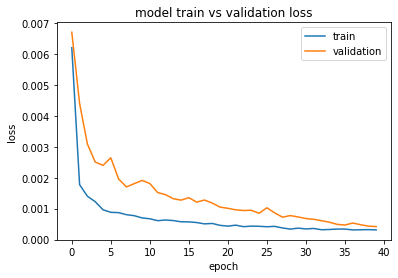

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [111]:
regressor.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 32)           4480      
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 7,633
Trainable params: 7,633
Non-trainable params: 0
_________________________________________________________________


In [112]:
regressor.save('my_modelp2.h5')

In [113]:
from keras.models import load_model
regressor = load_model('my_modelp2.h5')

In [114]:
predicted_stock_price = regressor.predict(X_train)

In [115]:
len(predicted_stock_price)

5249

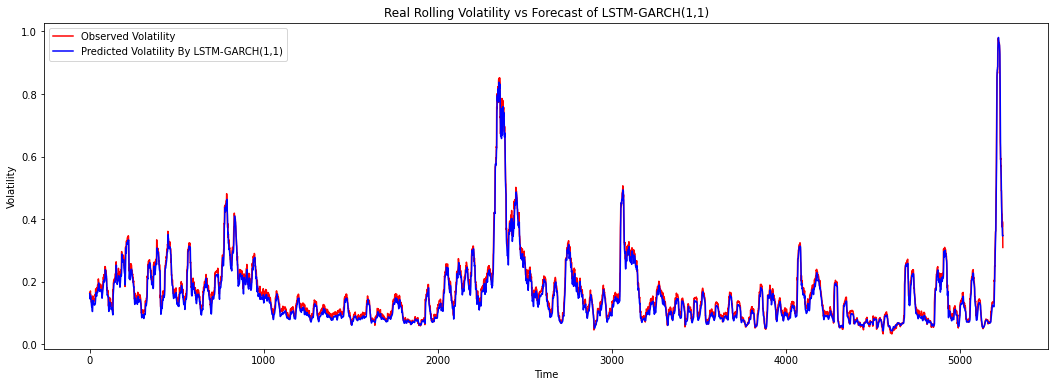

In [117]:
# Visualising the results
plt.figure(figsize=(18,6))
plt.plot(df.iloc[100:, 10:11].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM-GARCH(1,1)')
plt.title('Real Rolling Volatility vs Forecast of LSTM-GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [118]:
predicted_stock_price=[y for x in predicted_stock_price for y in x]


In [119]:
len(predicted_stock_price)

5249

In [120]:
real=df.iloc[100:, 11:12].values


In [121]:
real

array([[0.05581809],
       [0.05197172],
       [0.05693429],
       ...,
       [0.28453487],
       [0.27679851],
       [0.20204601]])

In [122]:
real=[y for x in real for y in x]

In [123]:
len(real)

5249

### MAE

In [124]:

for i in range(len(predicted_stock_price)):
    forecast_errors = predicted_stock_price[i]-real[i]


mae=np.mean(abs(forecast_errors))
print("Mean Absolute Error of the model is calculated as ",mae)

Mean Absolute Error of the model is calculated as  0.14564242212937062


###  RMSE

In [125]:
skor3 = rmse_tr(predicted_stock_price, np.array(df.loc[df.index[100:], 'Volatility']))
print("Root Mean Squared Error of the model is calculated as ",skor3)

Root Mean Squared Error of the model is calculated as  0.017342281830115793


### MAPE

In [126]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

mape=mean_absolute_percentage_error(real, predicted_stock_price)/len(predicted_stock_price)
print("Mean Absolute Percentage Error of the model is calculated as ",mape, "%")

Mean Absolute Percentage Error of the model is calculated as  0.055075968653977576 %


In [127]:
len(dates)

5369

In [128]:
days=dates[120:]

In [129]:
len(days)

5249

In [130]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x=days,
                y=real,
                name="Real Volatility",
                line_color='midnightblue',
                mode = 'lines+markers',
                opacity=0.7))

fig.add_trace(go.Scatter(
                x=days,
                y=predicted_stock_price,
                name="Predicted Volatility",
                mode = 'lines+markers',
                line_color='coral',
                opacity=0.7))



fig.update_layout(
    title="Daily Volatility Predictions",
    xaxis_title="Years: 2000-2020",
    yaxis_title="Daily Volatility",
    font=dict(
        family="Courier New, monospace",
        size=16,
        color="black"
    )
)

fig.update_layout(title_text='Daily Volatility Predictions',
                  xaxis_rangeslider_visible=True)

# Use date string to set xaxis range
fig.update_layout(xaxis_range=['2000-01-01','2020-05-09'],
                  title_text="Daily Volatility Predictions")
fig.show()





ply.offline.plot(fig, filename='daily_volatility.html')




'daily_volatility.html'

In [131]:
f={'Date':days, 'Daily Vol':predicted_stock_price}

final=pd.DataFrame(data=f)

final['Date'] = final['Date'].dt.strftime('%Y/%m/%d')

final.to_excel("predictions_GARCH_LSTM.xlsx")  

In [132]:
final.mean()

Daily Vol    0.154185
dtype: float64